# Information about dateset
- 40 000 rgb images
- 20 000 with cracks 
- 20 000 without cracks
- 75% of the data for training and rest for testing

- cracks can be confused with background texture or noise
- inhomogeneous illumination in pictures
- irreguralities in cracks

# Imports

In [2]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

# Preparing the data

In [3]:
directory = "data/images"
negative_file_path=os.path.join(directory,"Negative")
positive_file_path=os.path.join(directory,"Positive")

print(f"negative_file_path: {negative_file_path}\npositive_file_path: {positive_file_path}")


negative_file_path: data/images/Negative
positive_file_path: data/images/Positive


In [4]:
for file in  os.listdir(negative_file_path):
    os.path.join(negative_file_path,file)

for file in  os.listdir(positive_file_path):
    os.path.join(positive_file_path,file)

In [5]:
negative_files = []
for file in os.listdir(negative_file_path):
    if file.endswith(".jpg"):
        negative_files.append(os.path.join(negative_file_path,file))

positive_files = []
for file in os.listdir(positive_file_path):
    if file.endswith(".jpg"):
        positive_files.append(os.path.join(positive_file_path,file))

negative_files.sort()
positive_files.sort()


In [6]:
negative_files[0:3]

['data/images/Negative/00001.jpg',
 'data/images/Negative/00002.jpg',
 'data/images/Negative/00003.jpg']

In [7]:
positive_files[0:3]

['data/images/Positive/00001.jpg',
 'data/images/Positive/00002.jpg',
 'data/images/Positive/00003.jpg']

We have created 2 python lists for negative and positives images, we can view them with matplotlib as seen below

Text(0.5, 1.0, '1st Image With No Cracks')

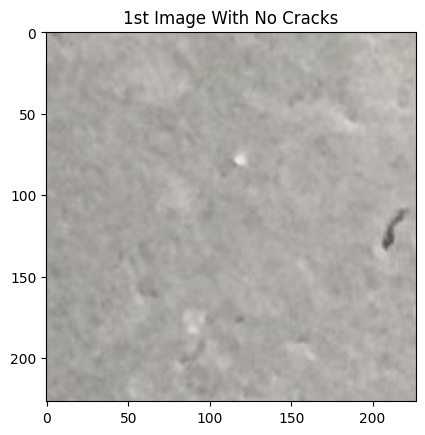

In [8]:
image1 = Image.open(negative_files[0])
plt.imshow(image1)
plt.title("1st Image With No Cracks")


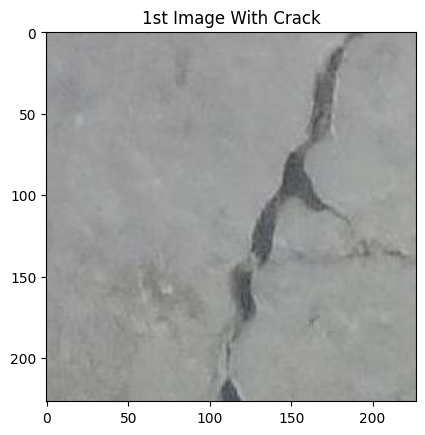

In [9]:
image2 = Image.open(positive_files[1])
plt.title("1st Image With Crack")
plt.imshow(image2)

# Preparing data for PyTorch
We have to combine images into a PyTorch Dataset object.

In [10]:
number_of_samples = len(positive_files) + len(negative_files)

Y = torch.zeros(number_of_samples)
Y = Y.type(torch.LongTensor)
Y[::2] = 1
Y[1::2] = 0

# Y = 1 0 1 0 1 0 1 0 ... 

This is a simple tensor to show which image is positive(1) and negative(0)

In [11]:
all_files = []

index = 0
for file in positive_files:
    all_files.insert(index, file)
    index += 2

index = 1
for file in negative_files:
    all_files.insert(index, file)
    index += 2


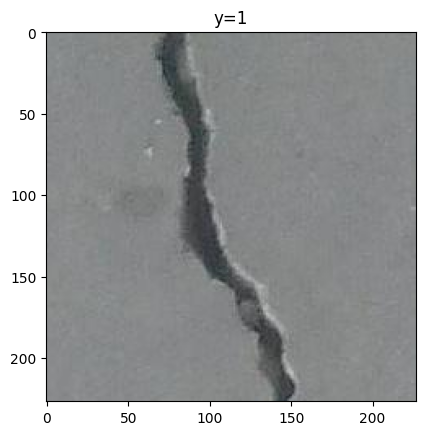

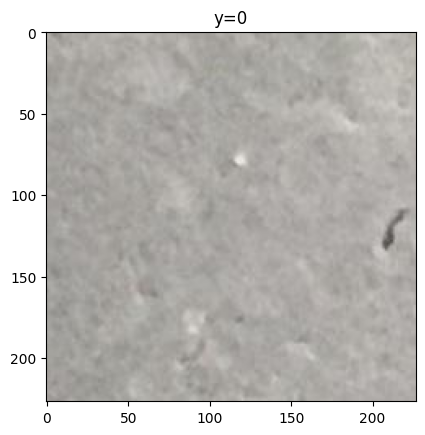

In [12]:
def show_n_items(n, data):
    for y,file in zip(Y, data[0:n]):
        plt.imshow(Image.open(file))
        plt.title("y="+str(y.item()))
        plt.show()

show_n_items(2, data= all_files)

### Combining Data into PyTorch DataSet
Now we can use this Dataset class to train our model.

In [13]:
class Dataset(Dataset):

    def __init__(self,transform,train=True):
        directory="data/images"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)

        for file in  os.listdir(negative_file_path):
            os.path.join(negative_file_path,file)

        for file in  os.listdir(positive_file_path):
            os.path.join(positive_file_path,file)

        negative_files = []
        for file in os.listdir(negative_file_path):
            if file.endswith(".jpg"):
                negative_files.append(os.path.join(negative_file_path,file))
        negative_files.sort()

        positive_files = []
        for file in os.listdir(positive_file_path):
            if file.endswith(".jpg"):
                positive_files.append(os.path.join(positive_file_path,file))
        positive_files.sort()

        self.all_files = []
        index = 0
        for file in positive_files:
            self.all_files.insert(index, file)
            index += 2
        index = 1
        for file in negative_files:
            self.all_files.insert(index, file)
            index += 2
        
        self.Y=torch.zeros([len(self.all_files)]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        self.transform = transform

        
        if train:
            self.all_files = self.all_files[:30000]
            self.Y=self.Y[:30000]
            self.len=len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
    
  
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, y

In [14]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

train_dataset = Dataset(train= True, transform= transform)
validation_dataset = Dataset(train= False, transform= transform)

Created 2 dataset objects for training and validation. They are transformed into a tensor and normalized.

# Linear Classifier with PyTorch

In [15]:
class Softmax(nn.Module):
    def __init__(self, input_size, out_size):
        super(Softmax, self).__init__()
        self.linear = nn.Linear(input_size, out_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [16]:
size_of_image=3*227*227 

model = Softmax(size_of_image, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum= 0.1)
criterion = torch.nn.CrossEntropyLoss()


In [17]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5)
validation_dataset_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=5)

Created model the optimizer, loss function, data loaders and metrics

In [18]:
n_epochs=5

accuracy_list=[]
N_test=len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_dataset_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, size_of_image))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

        correct=0
        for x_test, y_test in validation_dataset_loader:
            z = model(x_test.view(-1, size_of_image))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            
        accuracy = correct / N_test
        accuracy_list.append(accuracy)    

In [ ]:
#train_model(n_epochs)

Simple function to train the model with n epochs

In [ ]:
#torch.save(model.state_dict(),'model.pt')

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)

Saving and loading the trained model

# Using a pretrained PyTorch model

In [ ]:
pretrained_model = models.resnet18(pretrained= True)

composed_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

# we will only change the last layer of the pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

pretrained_model.fc = nn.Linear(512, 2)

pretrained_model_optimizer = torch.optim.Adam([parameters for parameters in pretrained_model.parameters() if parameters.requires_grad], lr=0.003)
# criterion, dataset loaders are the same 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


function to train the output of pretrained model

In [ ]:
n_epochs2 = 5
loss_list2 = []
accuracy_list2 = []
correct2 = 0
n_test2 = len(validation_dataset)

def train_pretrained_model():
    loss_sublist = []
    for epoch in range(n_epochs2):
        print(f'Epoch {epoch+1}/{n_epochs2}')
        for x, y in train_dataset_loader:
            pretrained_model.train()
            optimizer.zero_grad()
            z = pretrained_model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())
            loss.backward()
            optimizer.step()
        loss_list2.append(np.mean(loss_sublist))

        correct2 = 0
        for x_test, y_test in validation_dataset_loader:
            pretrained_model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct2 += (yhat == y_test).sum().item()
            accuracy = correct2 / n_test2
            accuracy_list2.append(accuracy)

In [ ]:
#train_pretrained_model()

In [ ]:
#torch.save(pretrained_model.state_dict(),'model2.pt')

In [ ]:
#model_path2 = 'model2.pt'
#spretrained_model = torch.load(model_path2)